# CTRL+MINd
**Mental Health In Tech**

## Libraries Importation

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## ForCasting

**Our Target to Forecast**

**✔ Current mental health state**

**✔ Productivity impact** 

**✔ MH resource awareness**


#### Forcasting SetUP

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ------------------------------------------------------
# 1. SETUP
# ------------------------------------------------------
df = CTRl_MIND_DF.copy()
year_col = "Survey_Year"

metrics = {
    "Current_MH_Disorder": "Do you currently have a mental health disorder?",
    "Productivity_Affected": "Do you believe your productivity is ever affected by a mental health issue?",
    "Awareness": "Do you know local or online resources to seek help for a mental health issue?",
}

**standardize values**

In [10]:
yes_values = ["yes",1]

# standardize all values to Yes=1, No=0
def clean_yes_no(val):
    if pd.isna(val):
        return np.nan
    return 1 if str(val).strip() in yes_values else 0

**Clean the dataset**

In [11]:
for metric in metrics.values():
    df[metric] = df[metric].apply(clean_yes_no)

**FORECASTING FUNCTIONs**

In [12]:
def forecast_metric(df, year_col, metric, metric_label):

    yearly = df.groupby(year_col)[metric].mean().reset_index()
    yearly = yearly.sort_values(year_col)

    last_year = int(yearly[year_col].max())
    H = 2030 - last_year

    y = yearly[metric].values

    try:
        # Try SARIMAX first
        model = SARIMAX(y, order=(1,1,1)).fit(disp=False)
        forecast = model.get_forecast(steps=H)
        mean_forecast = forecast.predicted_mean
        ci = forecast.conf_int()
        model_used = "SARIMAX"

        # Convert CI to numpy-friendly format
        if hasattr(ci, "iloc"):
            lower = ci.iloc[:, 0].values
            upper = ci.iloc[:, 1].values
        else:
            lower = ci[:, 0]
            upper = ci[:, 1]

    except Exception as e:
        # Fallback Holt-Winters
        model = ExponentialSmoothing(y, trend="add").fit()
        mean_forecast = model.forecast(H)

        lower = mean_forecast * 0.9
        upper = mean_forecast * 1.1
        model_used = "Holt-Winters"

    forecast_years = np.arange(last_year+1, 2031)

    forecast_df = pd.DataFrame({
        "Year": forecast_years,
        "Forecast": mean_forecast,
        "Lower_CI": lower,
        "Upper_CI": upper
    })

    return yearly, forecast_df, model_used


**Forcasting Plot**

In [13]:
def plot_forecast(yearly, forecast_df, metric_label, model_used):

    plt.figure(figsize=(10,5))

    # Historical
    plt.plot(
        yearly[year_col],
        yearly[yearly.columns[1]],
        marker='o',
        label="Historical"
    )

    # Forecast
    plt.plot(
        forecast_df["Year"],
        forecast_df["Forecast"],
        marker='o',
        linestyle='--',
        label="Forecast"
    )

    # CI
    plt.fill_between(
        forecast_df["Year"],
        forecast_df["Lower_CI"],
        forecast_df["Upper_CI"],
        alpha=0.2
    )

    plt.title(f"{metric_label} Forecast to 2030 ({model_used})")
    plt.xlabel("Year")
    plt.ylabel(metric_label)
    plt.grid(True)
    plt.legend()
    plt.show()

    print("\nForecast Table:")
    print(forecast_df)
    print("\n" + "="*80 + "\n")

#### Do you currently have a mental health disorder(FORCAST)

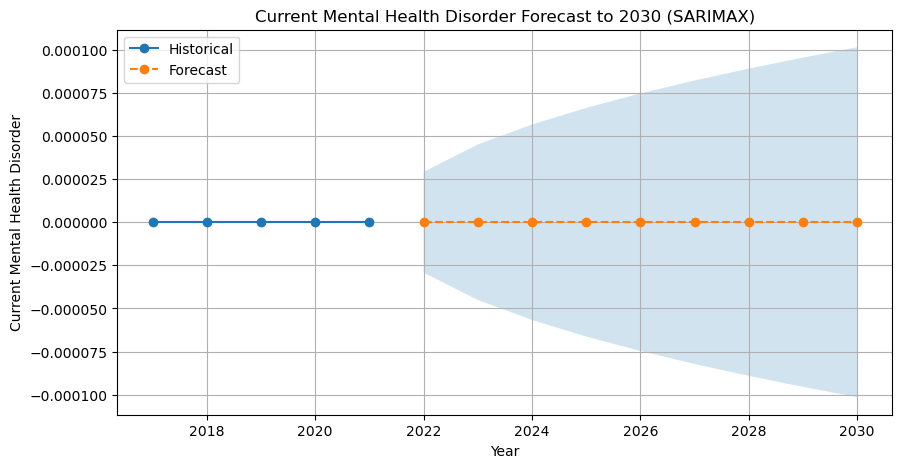


Forecast Table:
   Year  Forecast  Lower_CI  Upper_CI
0  2022       0.0 -0.000029  0.000029
1  2023       0.0 -0.000045  0.000045
2  2024       0.0 -0.000057  0.000057
3  2025       0.0 -0.000066  0.000066
4  2026       0.0 -0.000075  0.000075
5  2027       0.0 -0.000082  0.000082
6  2028       0.0 -0.000089  0.000089
7  2029       0.0 -0.000096  0.000096
8  2030       0.0 -0.000102  0.000102




In [14]:
yearly, forecast_df, model_used = forecast_metric(
    df, year_col, metrics["Current_MH_Disorder"], 
    "Current Mental Health Disorder"
)

plot_forecast(yearly, forecast_df, "Current Mental Health Disorder", model_used)


#### Has your productivity been affected by mental health(FORCASTING)

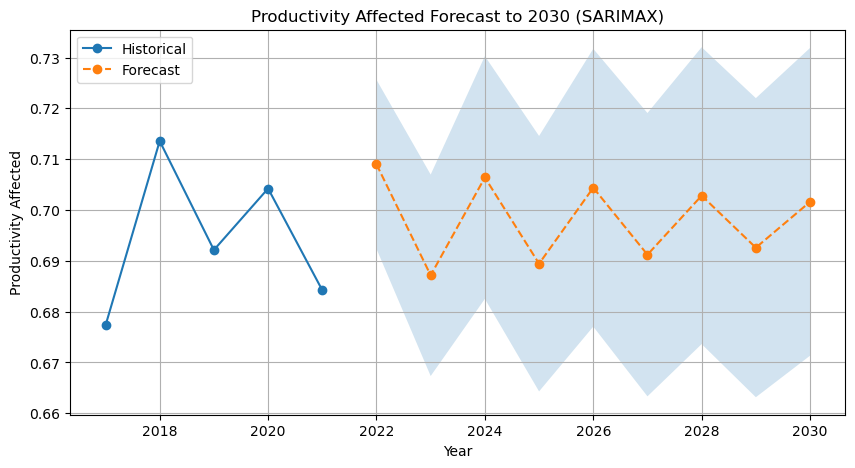


Forecast Table:
   Year  Forecast  Lower_CI  Upper_CI
0  2022  0.708983  0.692344  0.725622
1  2023  0.687148  0.667326  0.706970
2  2024  0.706394  0.682508  0.730280
3  2025  0.689430  0.664298  0.714562
4  2026  0.704382  0.677049  0.731715
5  2027  0.691203  0.663328  0.719078
6  2028  0.702820  0.673611  0.732028
7  2029  0.692580  0.663154  0.722007
8  2030  0.701605  0.671325  0.731886




In [15]:
yearly, forecast_df, model_used = forecast_metric(
    df, year_col, metrics["Productivity_Affected"], 
    "Productivity Affected"
)

plot_forecast(yearly, forecast_df, "Productivity Affected", model_used)

#### Are you aware of available mental health resources(FORCASTING)

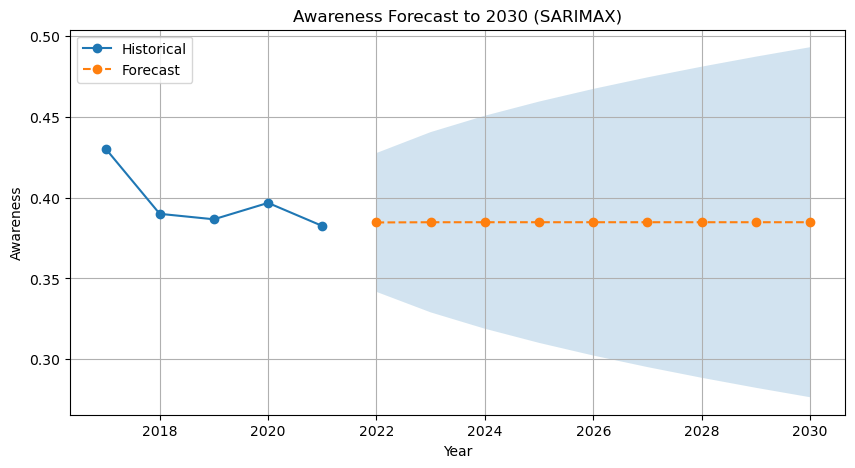


Forecast Table:
   Year  Forecast  Lower_CI  Upper_CI
0  2022  0.384618  0.341719  0.427518
1  2023  0.384752  0.329057  0.440446
2  2024  0.384760  0.318947  0.450572
3  2025  0.384760  0.310204  0.459317
4  2026  0.384760  0.302383  0.467138
5  2027  0.384760  0.295243  0.474278
6  2028  0.384760  0.288632  0.480888
7  2029  0.384760  0.282448  0.487073
8  2030  0.384760  0.276616  0.492905




In [16]:
yearly, forecast_df, model_used = forecast_metric(
    df, year_col, metrics["Awareness"], 
    "Awareness of MH Resources"
)

plot_forecast(yearly, forecast_df, "Awareness", model_used)

## ML (Random Forest)

### **Random Forest Model**

### SETUP

**Our Target using ML**

**✔ Current mental health state**

**✔ Productivity impact** 

**✔ MH resource awareness**

In [17]:
from sklearn.preprocessing import LabelEncoder

df_ml = CTRl_MIND_DF.copy()

target = "Do you currently have a mental health disorder?"

# حذف الصفوف الفارغة في الهدف
df_ml = df_ml.dropna(subset=[target])

# Label Encoding
le = LabelEncoder()
df_ml[target] = le.fit_transform(df_ml[target])

print("Classes:", le.classes_)
print(df_ml[target].value_counts())


Classes: ["Don't Know" 'No' 'Possibly' 'Yes']
Do you currently have a mental health disorder?
3    1814
1     768
2     575
0     335
Name: count, dtype: int64


**libraries Importation**

In [18]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

**Load & Prepare Data**

In [19]:
df = CTRl_MIND_DF.copy()
target = "Do you currently have a mental health disorder?"
df = df.dropna(subset=[target])


**Encode TARGET Only**

In [20]:
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])


**Data Encoding**

In [21]:
def convert_age(age):
    if isinstance(age, str) and "-" in age:
        a, b = age.split("-")
        return (int(a) + int(b)) / 2
    return age

if "What is your age?" in df.columns:
    df["What is your age?"] = df["What is your age?"].apply(convert_age)
label_encoders = {}

for col in df.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


**Outlier Removal**

In [22]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

condition = ~(
    (df[num_cols] < (Q1 - 1.5 * IQR)) |
    (df[num_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

df_clean = df[condition]

**Train / Test Split**

In [23]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

**RandomForest Training Phase**

In [24]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

### Model Evaluation

In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.79      0.98      0.87        53
           2       0.91      0.61      0.73        33
           3       1.00      0.78      0.88         9

    accuracy                           0.85       113
   macro avg       0.91      0.83      0.86       113
weighted avg       0.87      0.85      0.84       113

[[17  1  0  0]
 [ 1 52  0  0]
 [ 0 13 20  0]
 [ 0  0  2  7]]


#### Confusion Matrix

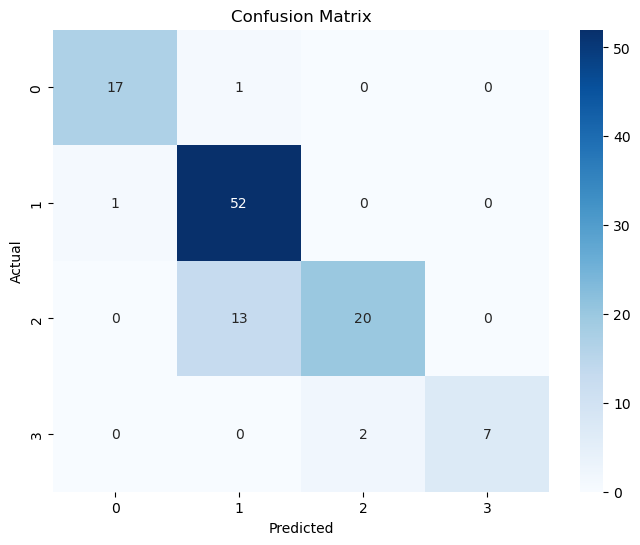

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Classification Report as Heatmap

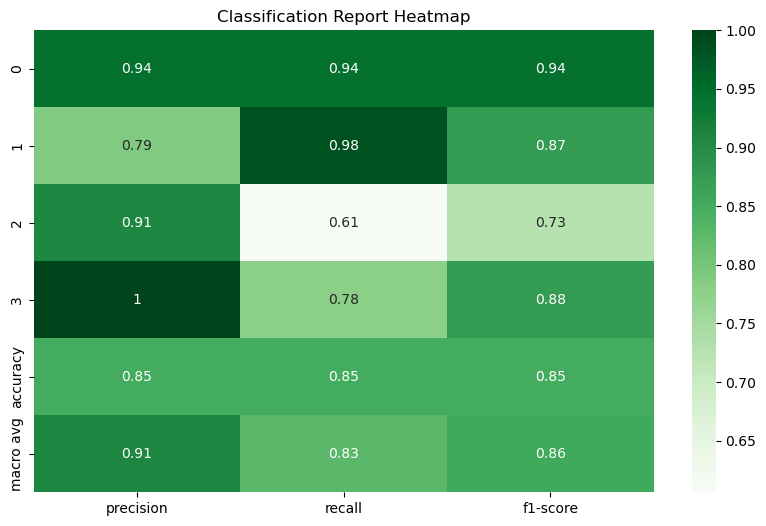

In [27]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T

plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Greens")
plt.title("Classification Report Heatmap")
plt.show()

#### Feature Importance (Top 20 only)

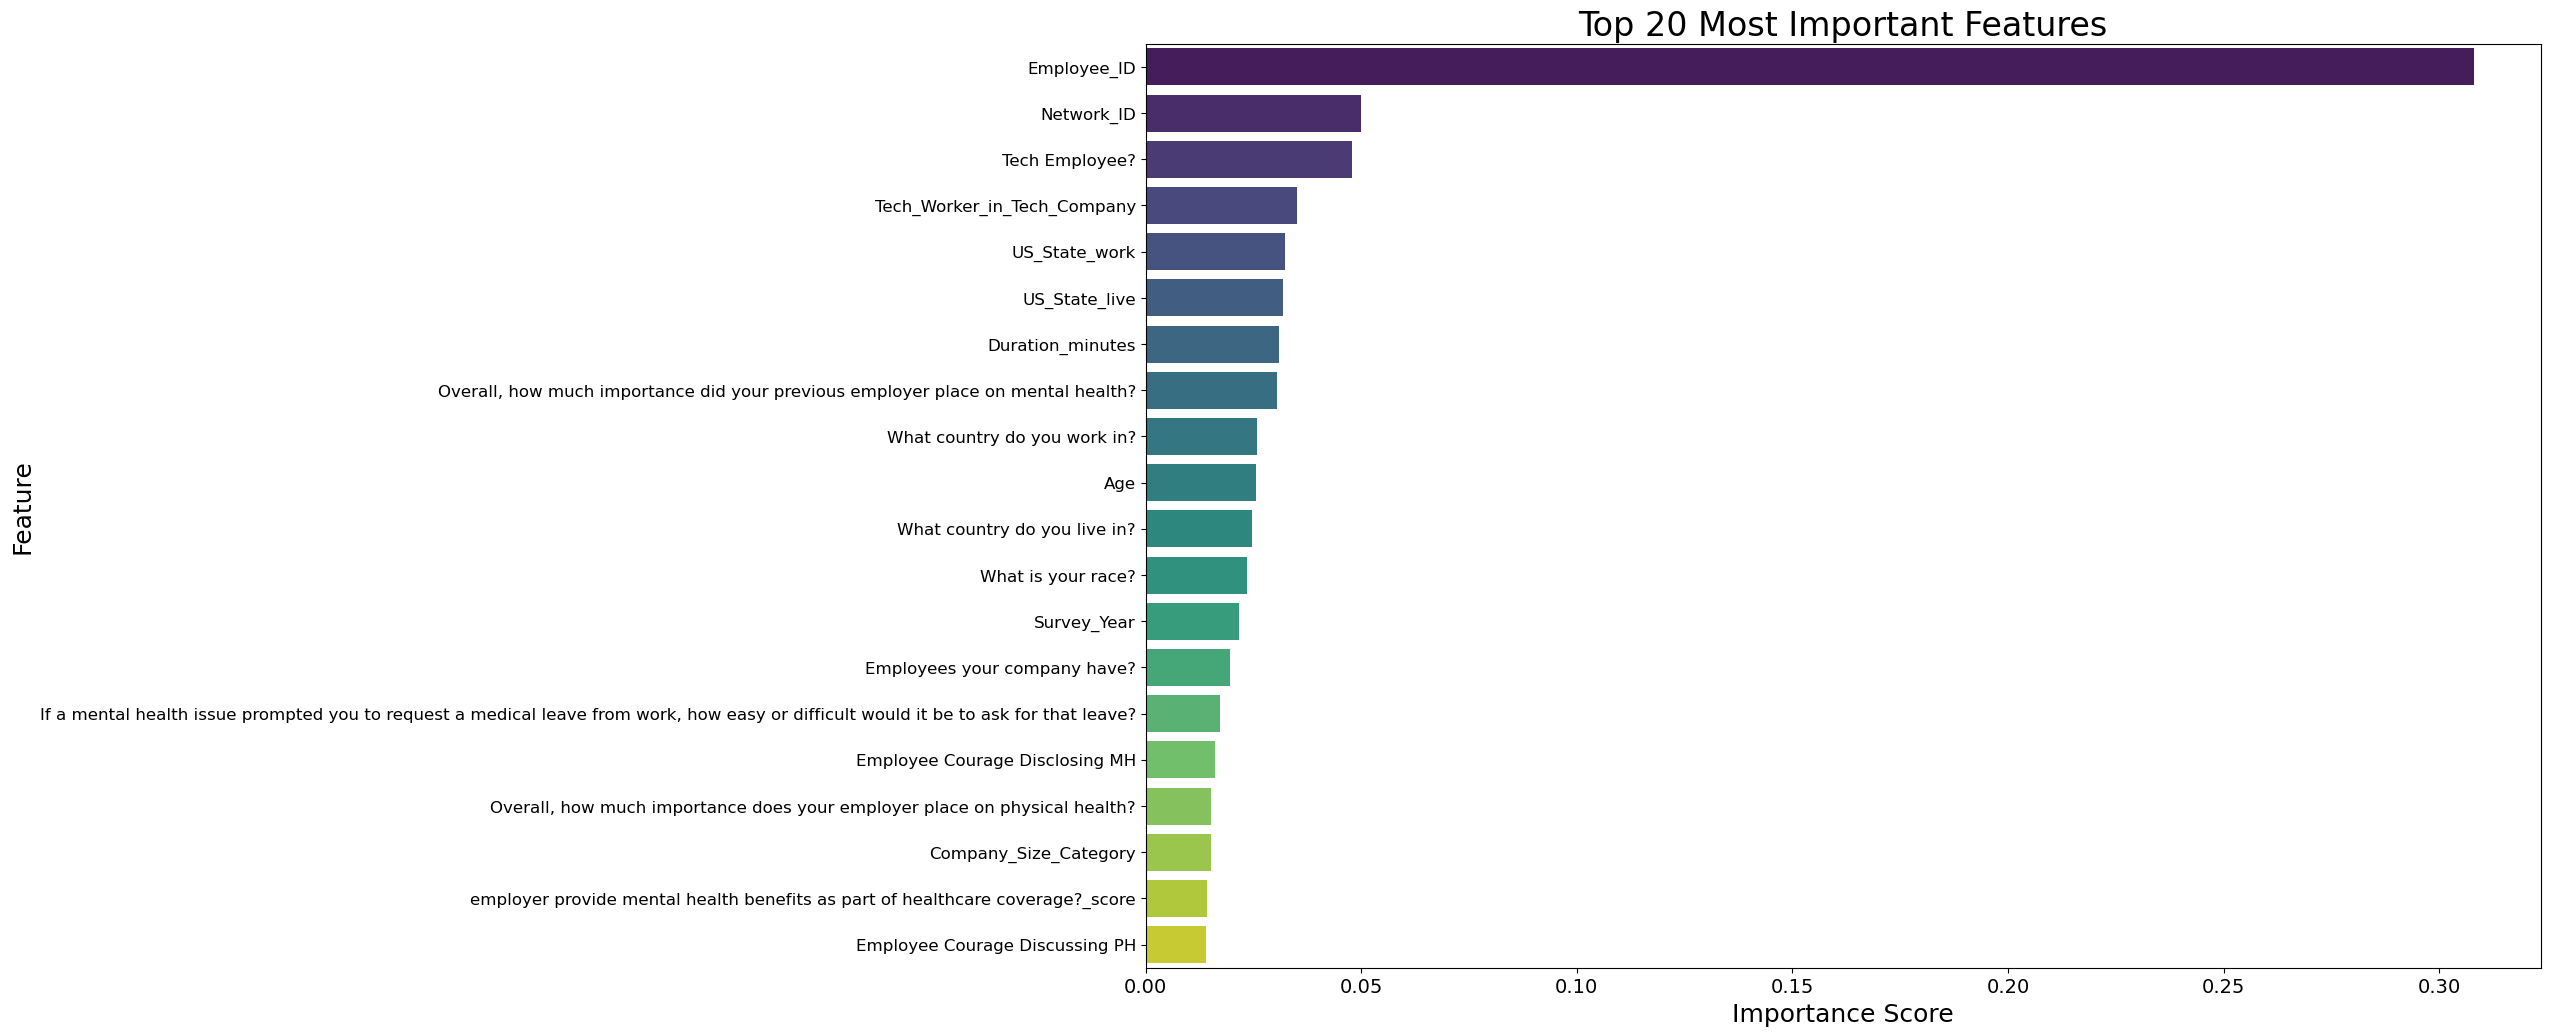

In [28]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(18,12))
sns.barplot(
    x=importances[indices][:20],
    y=X_train.columns[indices][:20],
    orient='h',
    palette="viridis"
)

plt.title("Top 20 Most Important Features", fontsize=24)
plt.xlabel("Importance Score", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

#### Class Distribution

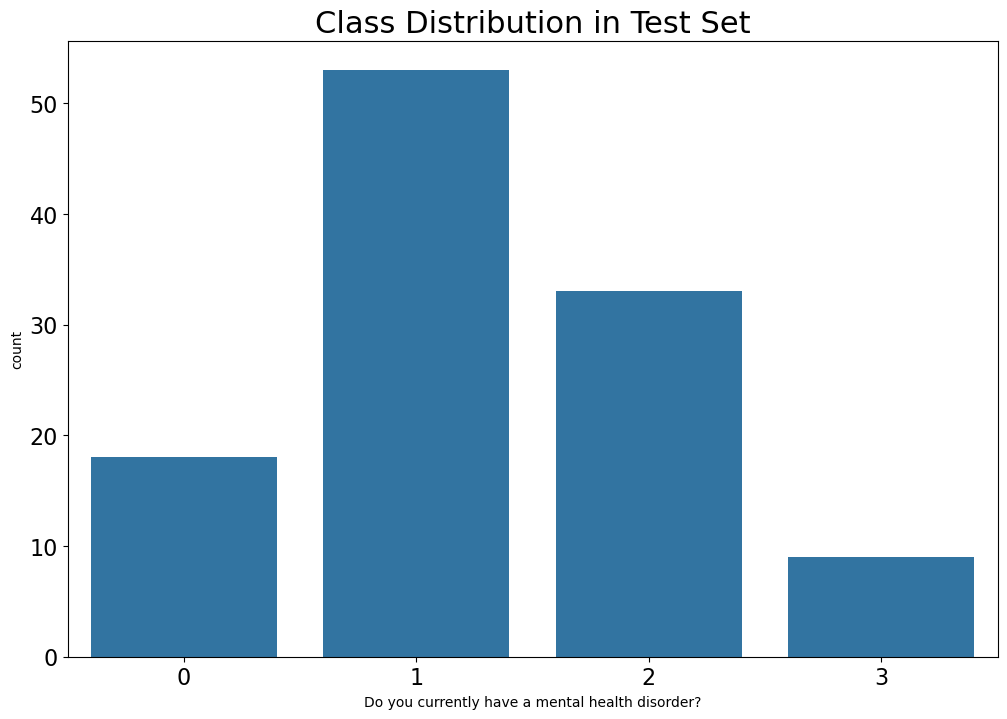

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x=y_test)
plt.title("Class Distribution in Test Set", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#### Actual vs Predicted

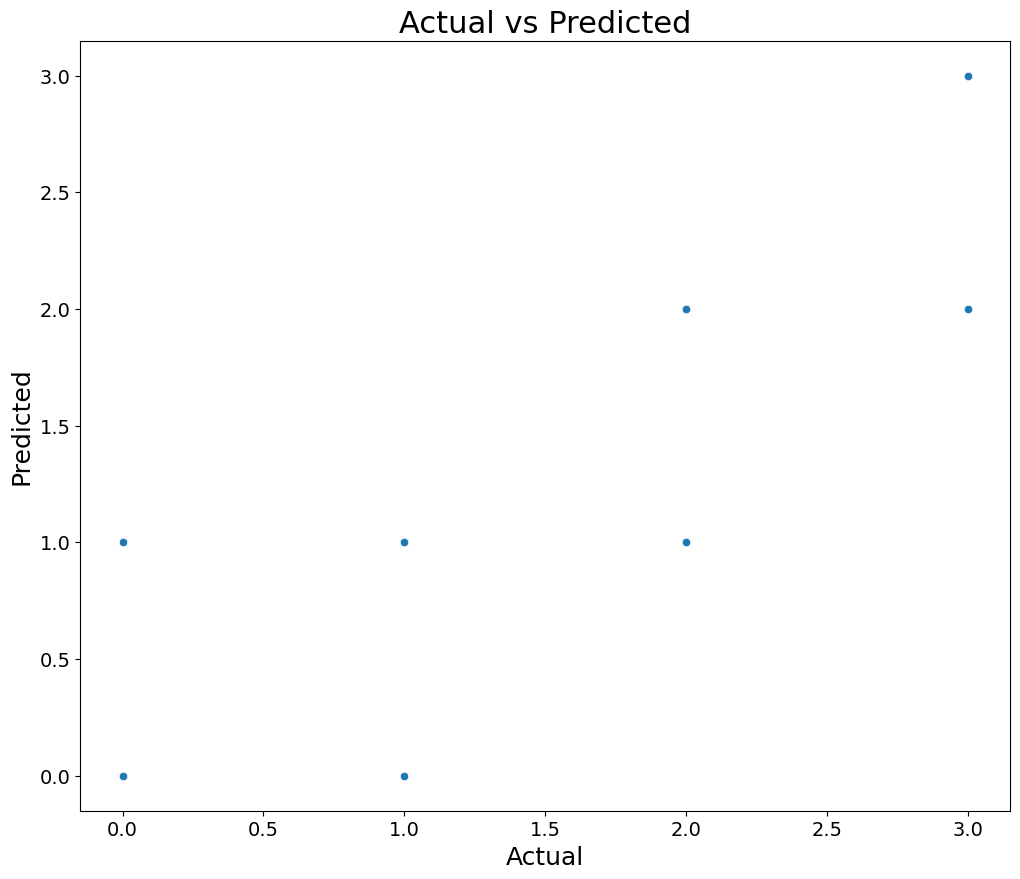

In [30]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred)
plt.title("Actual vs Predicted", fontsize=22)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### **CatBoost Model**

### SETUP

**Import Libraries**

In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier, Pool

**Load & Prepare Data**

In [32]:
df = CTRl_MIND_DF.copy()

target = "Do you currently have a mental health disorder?"
df = df.dropna(subset=[target])


**Encode TARGET Only**

In [33]:
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])

**Convert Age (18-24 → 21) + Keep categories as they are**

In [34]:
def convert_age(age):
    if isinstance(age, str) and "-" in age:
        a, b = age.split("-")
        return (int(a) + int(b)) / 2
    return age

if "What is your age?" in df.columns:
    df["What is your age?"] = df["What is your age?"].apply(convert_age)

**Split Features / Target**

In [35]:
X = df.drop(columns=[target])
y = df[target]


**Identify Categorical and Numeric Columns**

In [36]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

**Impute Missing Values**

In [37]:
# numeric
imp_num = SimpleImputer(strategy="median")
X[numeric_cols] = imp_num.fit_transform(X[numeric_cols])

# categorical
imp_cat = SimpleImputer(strategy="most_frequent")
X[categorical_cols] = imp_cat.fit_transform(X[categorical_cols])

**Apply Label Encoding ONLY to categorical features**

In [38]:
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

**Apply SMOTE**

In [39]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

**Train/Test Split**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.25,
    random_state=42,
    stratify=y_resampled
)

**CatBoost Model**

In [41]:
model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    verbose=False
)

**CatBoost Model Training**

In [42]:
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_cols)

model.fit(train_pool)

### ModelEvaluation

In [43]:
y_pred = model.predict(test_pool)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       454
           1       0.85      0.90      0.87       453
           2       0.86      0.87      0.87       454
           3       0.97      0.95      0.96       453

    accuracy                           0.92      1814
   macro avg       0.92      0.92      0.92      1814
weighted avg       0.92      0.92      0.92      1814


--- Confusion Matrix ---
[[425  24   5   0]
 [  7 407  37   2]
 [  0  47 397  10]
 [  2   0  20 431]]


#### Confusion Matrix

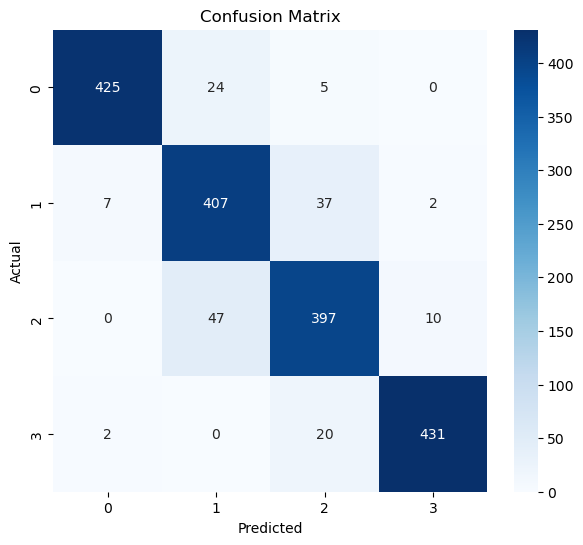

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Classification Report

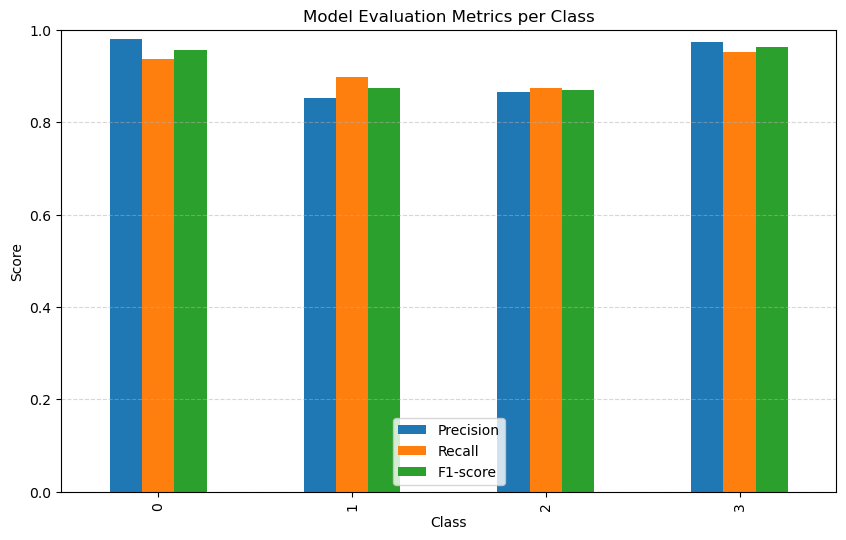

In [45]:
from sklearn.metrics import precision_recall_fscore_support

# استخراج المقاييس
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred)

df_scores = pd.DataFrame({
    "Class": range(len(prec)),
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1
})

df_scores.plot(x="Class", kind="bar", figsize=(10,6))
plt.title("Model Evaluation Metrics per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


#### Feature Importance

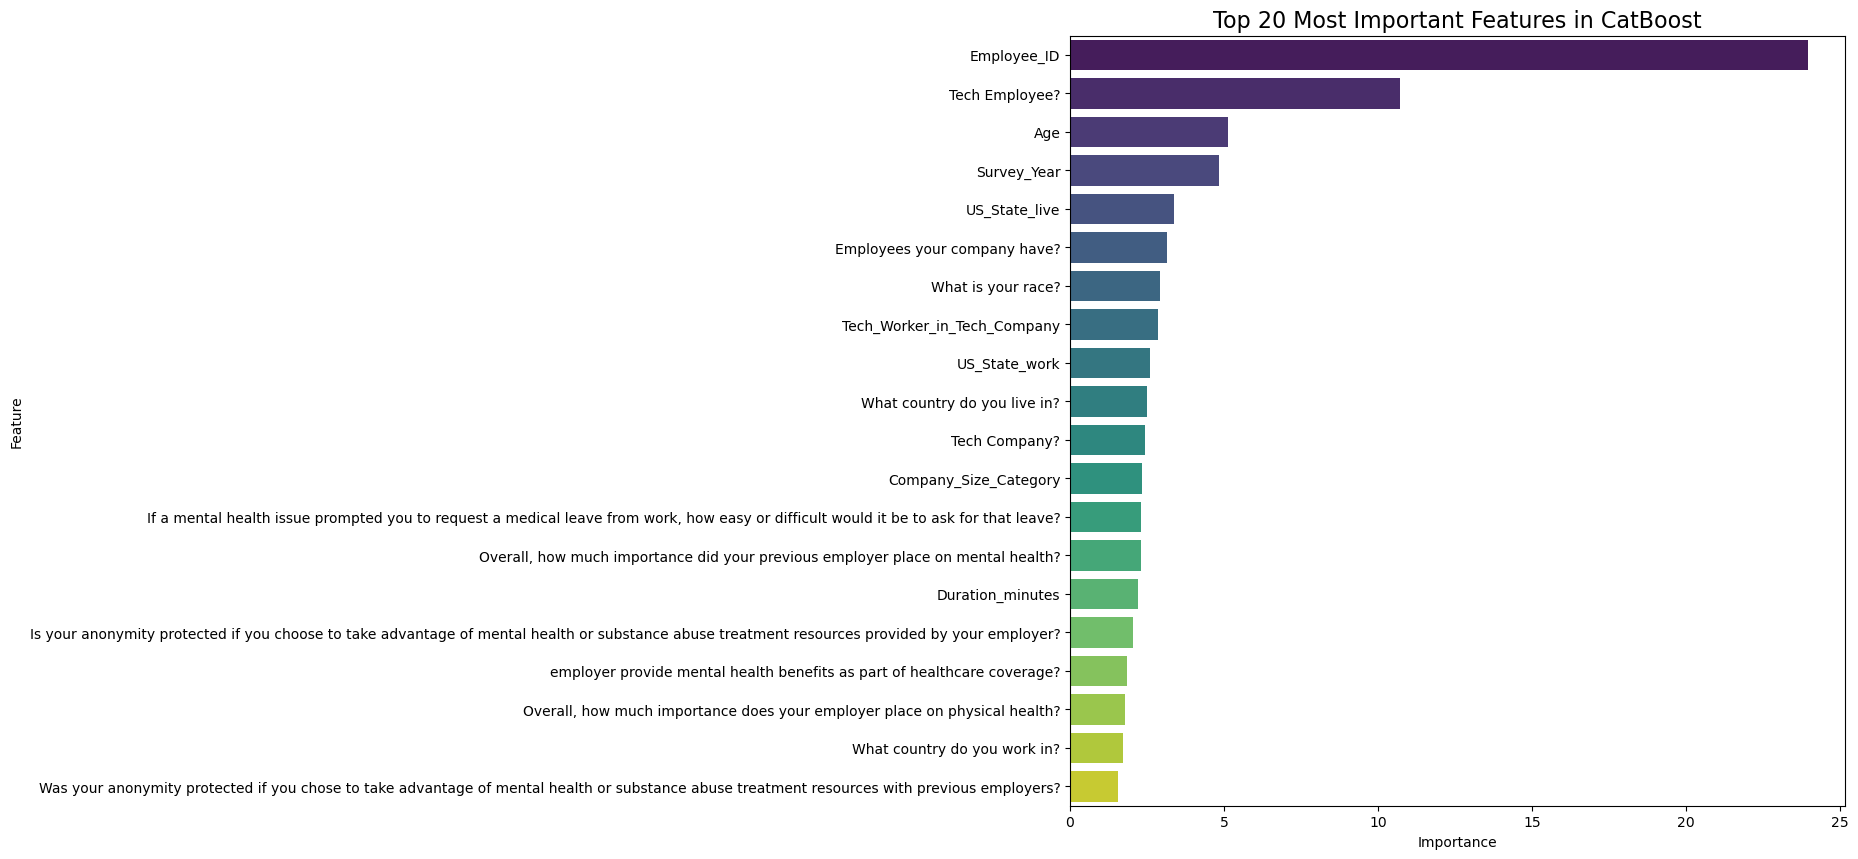

In [46]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# تحويلها إلى DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False)

# أخذ أعلى 20
fi_top20 = fi_df.head(20)

# رسمها
plt.figure(figsize=(10, 10))
sns.barplot(data=fi_top20, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Most Important Features in CatBoost", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()